<a href="https://colab.research.google.com/github/Akhilps04/Project-8/blob/main/FinalHRModelpynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Model Accuracy: 93.81%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       472
           1       0.85      0.97      0.91       472
           2       0.98      0.93      0.95       473
           3       0.99      0.95      0.97       472

    accuracy                           0.94      1889
   macro avg       0.94      0.94      0.94      1889
weighted avg       0.94      0.94      0.94      1889



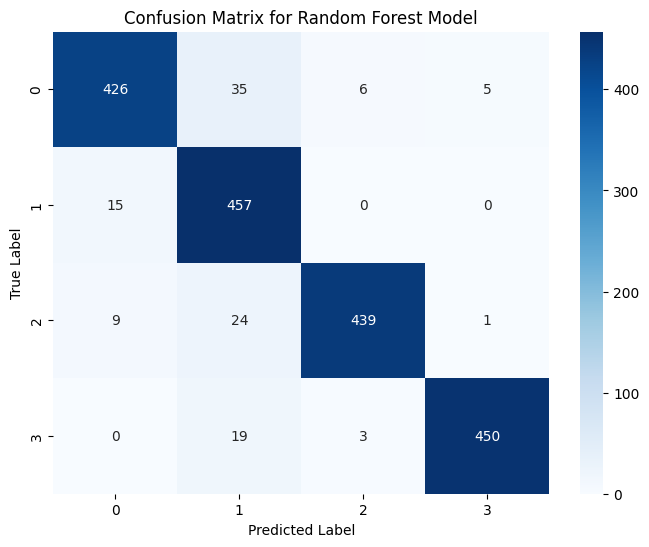

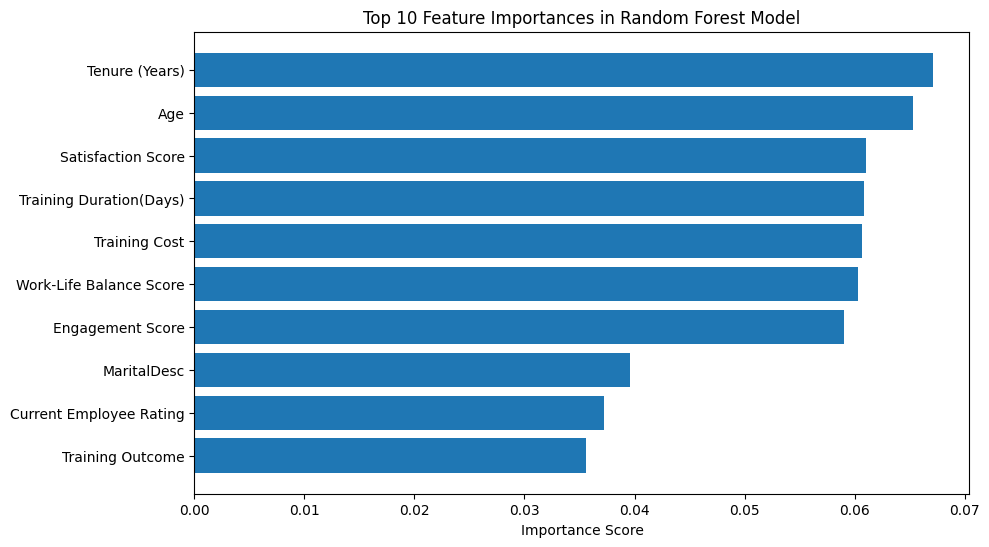

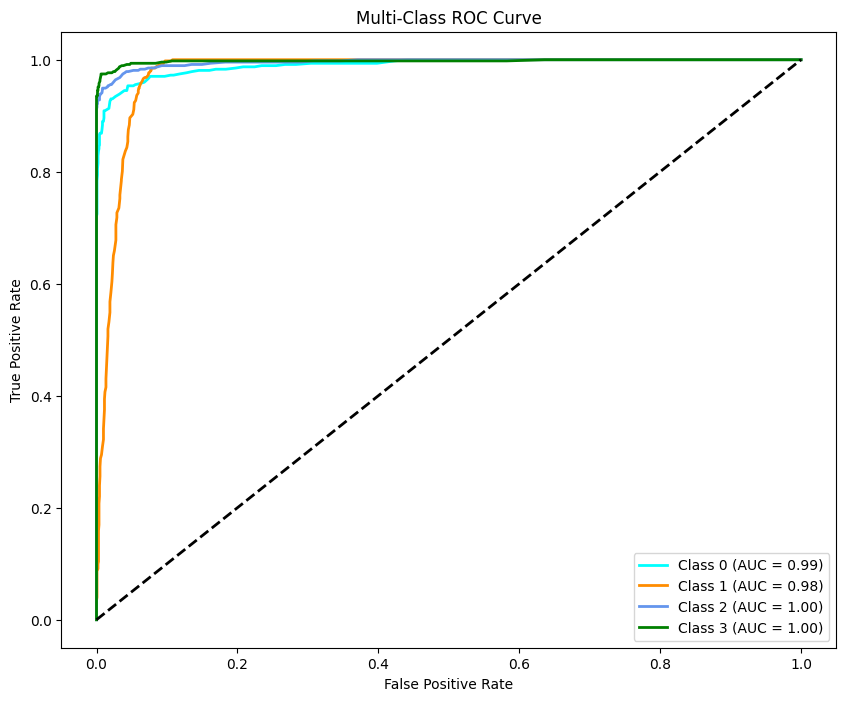

Cross-Validation Accuracy Scores: [0.75013235 0.97247221 0.97300159 0.98729487 0.96292373]
Mean Cross-Validation Accuracy: 0.93
Model metrics saved to 'model_metricsRF.json'
Model saved as 'employee_performance_RF_finalmodel.pkl'


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import json
from itertools import cycle
import joblib
# Load the processed dataset
data = pd.read_csv('/content/drive/MyDrive/complete_preprocessed_dataset1.csv')

# Step 1: Prepare features (X) and target (y)
target_label = 'Performance Score'
X = data.drop(columns=[target_label])
y = data[target_label]

# Step 2: Encode categorical features
binary_features = ['EmployeeStatus', 'EmployeeType', 'EmployeeClassificationType', 'GenderCode', 'MaritalDesc', 'Training Outcome']
label_encoders = {}
for feature in binary_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

# Step 3: Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Step 4: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Step 5: Train Random Forest model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 6: Model evaluation
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%\n")
classification_metrics = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(label) for label in sorted(y.unique())],
            yticklabels=[str(label) for label in sorted(y.unique())])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

# Step 7: Feature Importance Visualization
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_train.columns[indices][:10]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.barh(top_features, importances[indices][:10], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.show()

# Step 8: Generate ROC Curve for Multi-Class
# Binarize the output for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=sorted(y.unique()))
n_classes = y_test_binarized.shape[1]

# Predict probabilities
y_score = best_rf_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_score[:, i])

# Plot ROC Curves
plt.figure(figsize=(10, 8))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Perform cross-validation
scores = cross_val_score(best_rf_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(scores):.2f}")

# Step 9: Save Metrics to JSON File
metrics = {
    "precision": [classification_metrics[str(label)]["precision"] for label in sorted(y.unique())],
    "recall": [classification_metrics[str(label)]["recall"] for label in sorted(y.unique())],
    "f1_score": [classification_metrics[str(label)]["f1-score"] for label in sorted(y.unique())],
    "cv_accuracy_scores": cross_val_score(best_rf_model, X_resampled, y_resampled, cv=5, scoring='accuracy').tolist(),
    "classes": [str(label) for label in sorted(y.unique())],
    "feature_importances": {
        feature: importance for feature, importance in zip(X_train.columns, best_rf_model.feature_importances_)
    }
}

with open("model_metricsRF.json", "w") as f:
    json.dump(metrics, f)

print("Model metrics saved to 'model_metricsRF.json'")

# Save the trained model
joblib.dump(best_rf_model, 'employee_performance_RF_finalmodel.pkl')
print("Model saved as 'employee_performance_RF_finalmodel.pkl'")


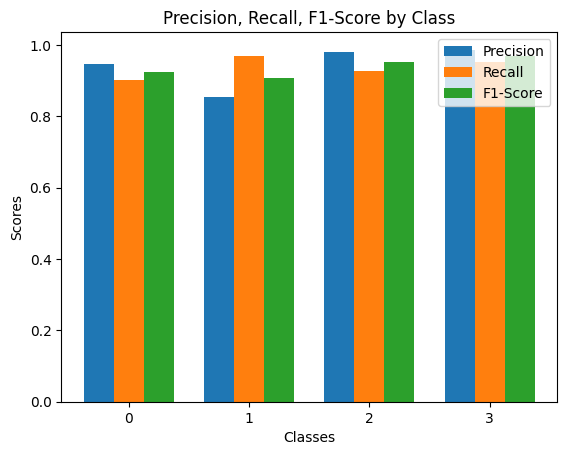

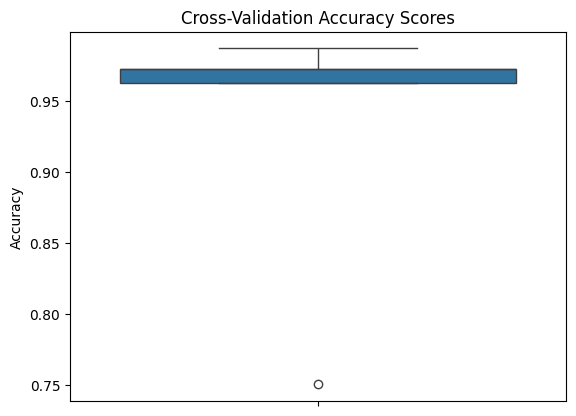

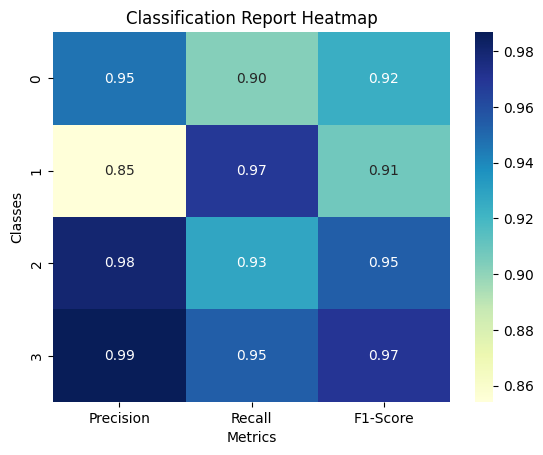

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load metrics from JSON file
with open("model_metricsRF.json", "r") as f:
    metrics = json.load(f)

# Extract metrics
classes = metrics["classes"]
precision = metrics["precision"]
recall = metrics["recall"]
f1_score = metrics["f1_score"]
cv_accuracy_scores = metrics["cv_accuracy_scores"]

# Plot 1: Precision, Recall, F1-Score by Class
fig, ax = plt.subplots()
x = np.arange(len(classes))
width = 0.25
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.show()

# Plot 2: Cross-Validation Accuracy Scores Boxplot
fig, ax = plt.subplots()
sns.boxplot(data=cv_accuracy_scores)
ax.set_title("Cross-Validation Accuracy Scores")
ax.set_ylabel("Accuracy")

plt.show()

# Plot 3: Classification Report Heatmap
classification_metrics = np.array([precision, recall, f1_score]).T  # Transpose for heatmap
metric_labels = ['Precision', 'Recall', 'F1-Score']

fig, ax = plt.subplots()
sns.heatmap(classification_metrics, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True,
            xticklabels=metric_labels, yticklabels=classes)
ax.set_title("Classification Report Heatmap")
ax.set_xlabel("Metrics")
ax.set_ylabel("Classes")

plt.show()
